In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import datasets
%matplotlib inline

In [2]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

In [3]:
x,y=load_planar_dataset()

In [4]:
print(x.shape)
print(y.shape)

(2, 400)
(1, 400)


In [5]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y.ravel(), cmap=plt.cm.Spectral)

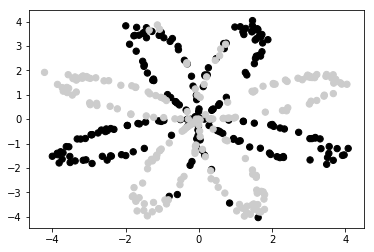

In [6]:
plt.scatter(x[0,:],x[1,:],c=y[0,:],s=40,cmap=plt.cm.spectral)

In [7]:
clf=linear_model.LogisticRegressionCV(cv=5)
clf.fit(x.T,y.T.ravel())

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


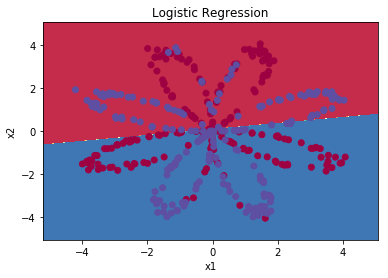

In [8]:
plot_decision_boundary(lambda x: clf.predict(x), x, y)
plt.title("Logistic Regression")
LR_predictions = clf.predict(x.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(y,LR_predictions) + np.dot(1-y,1-LR_predictions))/float(y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

In [9]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

In [10]:
def layer_sizes(X, Y):
    n_x = X.shape[0] 
    n_h = 4
    n_y = Y.shape[0] 
    return (n_x, n_h, n_y)

In [11]:
def initialize_parameters(n_x,n_h,n_y):
    W1=np.random.randn(n_h,n_x)*0.01
    b1=np.zeros((n_h,1))
    W2=np.random.randn(n_y,n_h)*0.01
    b2=np.zeros((n_y,1))
    parameters={'W1':W1,'b1':b1,'W2':W2,'b2':b2}
    return parameters

In [12]:
def forward_propagation(x,parameters):
    W1=parameters['W1']
    W2=parameters['W2']
    b1=parameters['b1']
    b2=parameters['b2']
    Z1=np.dot(W1,x)+b1
    A1=np.tanh(Z1)
    Z2=np.dot(W2,A1)+b2
    A2=sigmoid(Z2)
    cache={'Z1':Z1,'Z2':Z2,'A1':A1,'A2':A2}
    return A2,cache

In [13]:
def compute_cost(A2, Y, parameters):
    m = Y.shape[1] 
    logprobs = np.multiply(np.log(A2), Y) + np.multiply((1-Y), np.log(1-A2))
    cost = -1/m * np.sum(logprobs) 
    cost = np.squeeze(cost)      
    return cost

In [14]:
# GRADED FUNCTION: backward_propagation

def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    dZ2= A2 - Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), (1 - np.power(A1, 2)))
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [15]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [16]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    for i in range(0, num_iterations):
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y, parameters)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads)
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    return parameters

In [17]:
def predict(parameters, X):
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)
    return predictions

Cost after iteration 0: 0.693162
Cost after iteration 1000: 0.258625
Cost after iteration 2000: 0.239334
Cost after iteration 3000: 0.230802
Cost after iteration 4000: 0.225528
Cost after iteration 5000: 0.221845
Cost after iteration 6000: 0.219094
Cost after iteration 7000: 0.220621
Cost after iteration 8000: 0.219414
Cost after iteration 9000: 0.218527


Text(0.5,1,'Decision Boundary for hidden layer size 4')

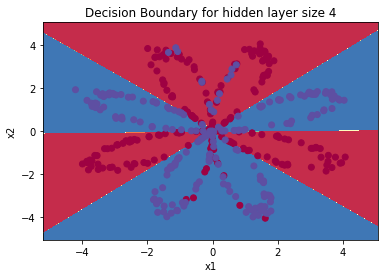

In [18]:
parameters = nn_model(x, y, n_h = 4, num_iterations = 10000, print_cost=True)
plot_decision_boundary(lambda x: predict(parameters, x.T), x, y)
plt.title("Decision Boundary for hidden layer size " + str(4))

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 91.0 %
Accuracy for 50 hidden units: 90.5 %


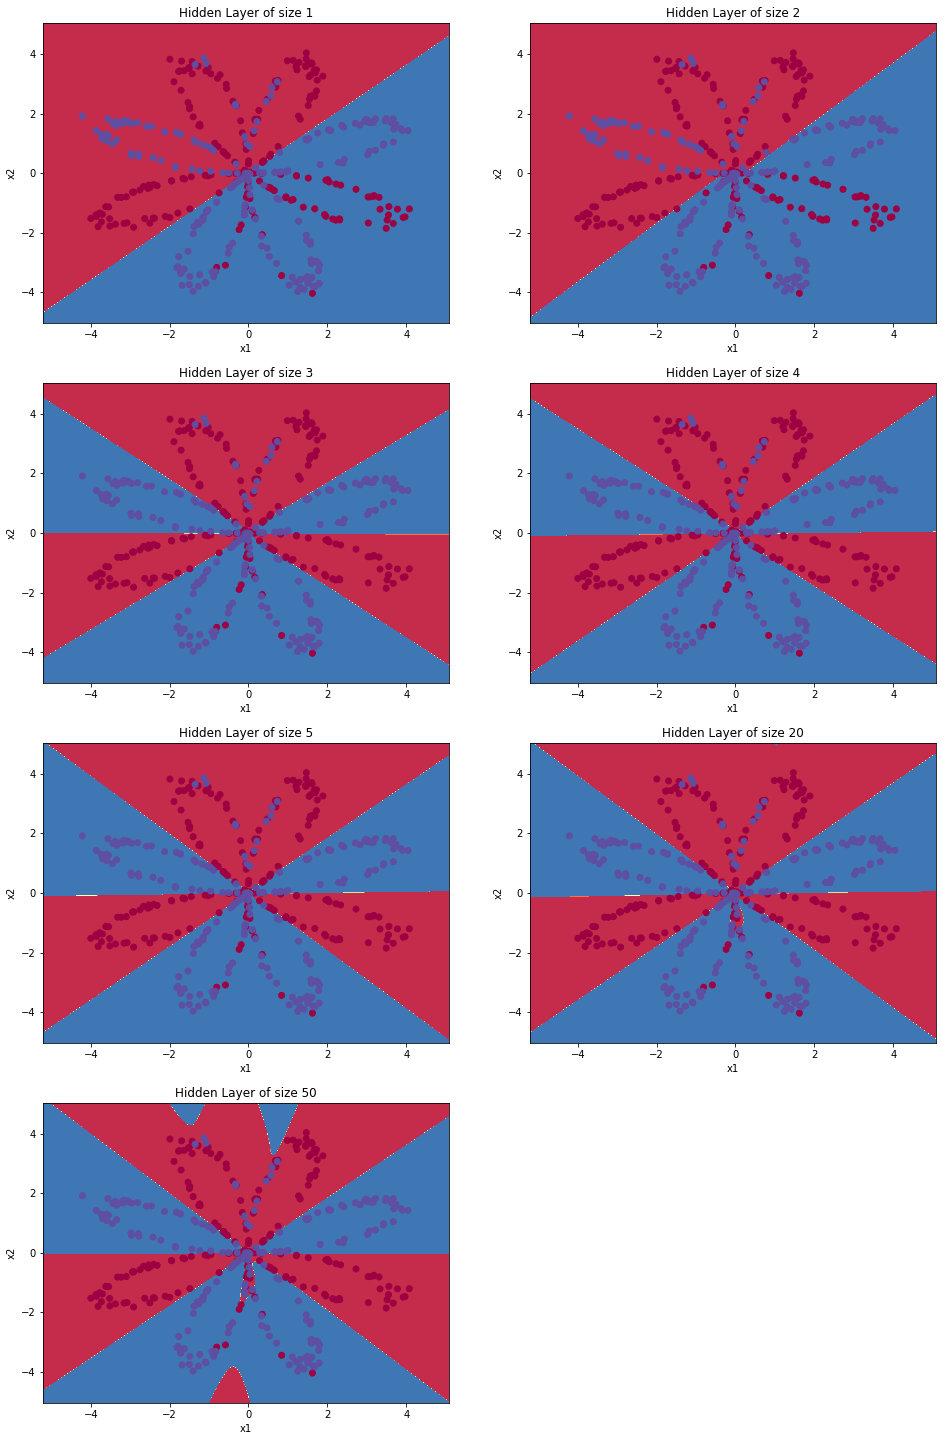

In [20]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(x, y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), x, y)
    predictions = predict(parameters, x)
    accuracy = float((np.dot(y,predictions.T) + np.dot(1-y,1-predictions.T))/float(y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))